In [153]:
import numpy as np
import math
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from collections import namedtuple

from PIL import Image
import os
import os.path
import errno
import codecs
import copy

import time

In [154]:
print('starts')

starts


In [155]:
torch.manual_seed(0)
np.random.seed(0)
print("torch.cuda.device_count()", torch.cuda.device_count())
print("torch.cuda.current_device()", torch.cuda.current_device())
torch.cuda.set_device(2)
print("torch.cuda.current_device()", torch.cuda.current_device())

torch.cuda.device_count() 4
torch.cuda.current_device() 2
torch.cuda.current_device() 2


In [156]:
def compute_ranks(x):
  """
  Returns ranks in [0, len(x))
  Note: This is different from scipy.stats.rankdata, which returns ranks in [1, len(x)].
  (https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py)
  """
  assert x.ndim == 1
  ranks = np.empty(len(x), dtype=int)
  ranks[x.argsort()] = np.arange(len(x))
  return ranks

def compute_centered_ranks(x):
  """
  https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py
  """
  y = compute_ranks(x.ravel()).reshape(x.shape).astype(np.float32)
  y /= (x.size - 1)
  y -= .5
  return y

def compute_weight_decay(weight_decay, model_param_list):
  model_param_grid = np.array(model_param_list)
  return - weight_decay * np.mean(model_param_grid * model_param_grid, axis=1)

class CMAES:
  '''CMA-ES wrapper.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               popsize=255,           # population size
               done_threshold=1e-6,   # threshold when we say we are done
               weight_decay=0.01):    # weight decay coefficient

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.done_threshold = done_threshold
    self.popsize = popsize
    self.weight_decay = weight_decay
    self.solutions = None

    import cma
    self.es = cma.CMAEvolutionStrategy( self.num_params * [0],
                                        self.sigma_init,
                                        {'popsize': self.popsize,
                                         'ftarget': self.done_threshold,
                                        })

  def rms_stdev(self):
    sigma = self.es.result[6]
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    self.solutions = np.array(self.es.ask())
    return self.solutions

  def tell(self, reward_table_result):
    reward_table = -np.array(reward_table_result)
    if self.weight_decay > 0:
      l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
      reward_table += l2_decay
    self.es.tell(self.solutions, (reward_table).tolist()) # convert minimizer to maximizer.

  def done(self):
    return self.es.stop()

  def current_param(self):
    return self.es.result[5] # mean solution, presumably better with noise
  
  def best_param(self):
    return self.es.result[0] # best evaluated solution

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    r = self.es.result
    return (r[0], -r[1], -r[1], r[6])

class SimpleES:
  '''Simple Evolution Strategies.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               sigma_alpha=0.20,      # learning rate for standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=255,           # population size
               elite_ratio=0.1,       # percentage of the elites
               done_threshold=1e-6,   # threshold when we say we are done
               average_baseline=True, # set baseline to average of batch
               weight_decay=0.01,     # weight decay coefficient
               rank_fitness=True,     # use rank rather than fitness numbers
               forget_best=True):     # don't keep the historical best solution

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_alpha = sigma_alpha
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize
    self.average_baseline = average_baseline
    if self.average_baseline:
      assert (self.popsize % 2 == 0), "Population size must be even"
      self.batch_size = int(self.popsize / 2)
    else:
      assert (self.popsize & 1), "Population size must be odd"
      self.batch_size = int((self.popsize - 1) / 2)
    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)
    self.forget_best = forget_best
    self.batch_reward = np.zeros(self.batch_size * 2)
    self.mu = np.zeros(self.num_params)
    self.sigma = np.ones(self.num_params) * self.sigma_init
    self.curr_best_mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.weight_decay = weight_decay
    self.rank_fitness = rank_fitness
    if self.rank_fitness:
      self.forget_best = True # always forget the best one if we rank
    self.done_threshold = done_threshold

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.batch_size, self.num_params) * self.sigma.reshape(1, self.num_params)
    self.epsilon_full = np.concatenate([self.epsilon, - self.epsilon])
    if self.average_baseline:
      epsilon = self.epsilon_full
    else:
      # first population is mu, then positive epsilon, then negative epsilon
      epsilon = np.concatenate([np.zeros((1, self.num_params)), self.epsilon_full])
    solutions = self.mu.reshape(1, self.num_params) + epsilon
    self.solutions = solutions
    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."

    reward_table = np.array(reward_table_result)
    
    if self.rank_fitness:
      reward_table = compute_centered_ranks(reward_table)
    
    if self.weight_decay > 0:
      l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
      reward_table += l2_decay

    reward_offset = 1
    if self.average_baseline:
      b = np.mean(reward_table)
      reward_offset = 0
    else:
      b = reward_table[0] # baseline
      
    reward = reward_table[reward_offset:]
    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    best_reward = reward[idx[0]]
    if (best_reward > b or self.average_baseline):
      best_mu = self.mu + self.epsilon_full[idx[0]]
      best_reward = reward[idx[0]]
    else:
      best_mu = self.mu
      best_reward = b

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # adaptive sigma
    # normalization
    stdev_reward = reward.std()
    epsilon = self.epsilon
    sigma = self.sigma
    S = ((epsilon * epsilon - (sigma * sigma).reshape(1, self.num_params)) / sigma.reshape(1, self.num_params))
    reward_avg = (reward[:self.batch_size] + reward[self.batch_size:]) / 2.0
    rS = reward_avg - b
    delta_sigma = (np.dot(rS, S)) / (2 * self.batch_size * stdev_reward)

    # move mean to the average of the best idx means
    self.mu += self.epsilon_full[idx].mean(axis=0)

    # adjust sigma according to the adaptive sigma calculation
    change_sigma = self.sigma_alpha * delta_sigma
    change_sigma = np.minimum(change_sigma, self.sigma)
    change_sigma = np.maximum(change_sigma, - 0.5 * self.sigma)
    self.sigma += change_sigma
    self.sigma[self.sigma > self.sigma_limit] *= self.sigma_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.curr_best_mu
  
  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

class SimpleGA:
  '''Simple Genetic Algorithm.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.1,        # initial standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=255,           # population size
               elite_ratio=0.1,       # percentage of the elites
               forget_best=False,     # forget the historical best elites
               weight_decay=0.01,     # weight decay coefficient
              ):

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize

    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)

    self.sigma = self.sigma_init
    self.elite_params = np.zeros((self.elite_popsize, self.num_params))
    self.elite_rewards = np.zeros(self.elite_popsize)
    self.best_param = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_iteration = True
    self.forget_best = forget_best
    self.weight_decay = weight_decay

  def rms_stdev(self):
    return self.sigma # same sigma for all parameters.

  def ask(self):
    '''returns a list of parameters'''
    self.epsilon = np.random.randn(self.popsize, self.num_params) * self.sigma
    solutions = []
    
    def mate(a, b):
      c = np.copy(a)
      idx = np.where(np.random.rand((c.size)) > 0.5)
      c[idx] = b[idx]
      return c
    
    elite_range = range(self.elite_popsize)
    for i in range(self.popsize):
      idx_a = np.random.choice(elite_range)
      idx_b = np.random.choice(elite_range)
      child_params = mate(self.elite_params[idx_a], self.elite_params[idx_b])
      solutions.append(child_params + self.epsilon[i])

    solutions = np.array(solutions)
    self.solutions = solutions

    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."

    reward_table = np.array(reward_table_result)
    
    if self.weight_decay > 0:
      l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
      reward_table += l2_decay

    if (not self.forget_best or self.first_iteration):
      reward = reward_table
      solution = self.solutions
    else:
      reward = np.concatenate([reward_table, self.elite_rewards])
      solution = np.concatenate([self.solutions, self.elite_params])

    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    self.elite_rewards = reward[idx]
    self.elite_params = solution[idx]

    self.curr_best_reward = self.elite_rewards[0]
    
    if self.first_iteration or (self.curr_best_reward > self.best_reward):
      self.first_iteration = False
      self.best_reward = self.elite_rewards[0]
      self.best_param = np.copy(self.elite_params[0])

    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.elite_params[0]

  def best_param(self):
    return self.best_param

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_param, self.best_reward, self.curr_best_reward, self.sigma)

class OpenES:
  ''' Basic Version of OpenAI Evolution Strategies.'''
  def __init__(self, num_params,             # number of model parameters
               sigma_init=0.1,               # initial standard deviation
               sigma_decay=0.999,            # anneal standard deviation
               sigma_limit=0.01,             # stop annealing if less than this
               learning_rate=0.01,           # learning rate for standard deviation
               learning_rate_decay = 0.9999, # annealing the learning rate
               learning_rate_limit = 0.001,  # stop annealing learning rate
               popsize=255,                  # population size
               antithetic=False,             # whether to use antithetic sampling
               weight_decay=0.01,            # weight decay coefficient
               rank_fitness=True,            # use rank rather than fitness numbers
               forget_best=True):            # forget historical best

    self.num_params = num_params
    self.sigma_decay = sigma_decay
    self.sigma = sigma_init
    self.sigma_limit = sigma_limit
    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay
    self.learning_rate_limit = learning_rate_limit
    self.popsize = popsize
    self.antithetic = antithetic
    if self.antithetic:
      assert (self.popsize % 2 == 0), "Population size must be even"
      self.half_popsize = int(self.popsize / 2)

    self.reward = np.zeros(self.popsize)
    self.mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.forget_best = forget_best
    self.weight_decay = weight_decay
    self.rank_fitness = rank_fitness
    if self.rank_fitness:
      self.forget_best = True # always forget the best one if we rank

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    if self.antithetic:
      self.epsilon_half = np.random.randn(self.half_popsize, self.num_params)
      self.epsilon = np.concatenate([self.epsilon_half, - self.epsilon_half])
    else:
      self.epsilon = np.random.randn(self.popsize, self.num_params)

    self.solutions = self.mu.reshape(1, self.num_params) + self.epsilon * self.sigma

    return self.solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."
    
    reward = np.array(reward_table_result)
    
    if self.rank_fitness:
      reward = compute_centered_ranks(reward)
    
    if self.weight_decay > 0:
      l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
      reward += l2_decay

    idx = np.argsort(reward)[::-1]

    best_reward = reward[idx[0]]
    best_mu = self.solutions[idx[0]]

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # main bit:
    # standardize the rewards to have a gaussian distribution
    normalized_reward = (reward - np.mean(reward)) / np.std(reward)
    self.mu += self.learning_rate/(self.popsize*self.sigma)*np.dot(self.epsilon.T, normalized_reward)

    # adjust sigma according to the adaptive sigma calculation
    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

    if (self.learning_rate > self.learning_rate_limit):
      self.learning_rate *= self.learning_rate_decay

  def done(self):
    return False

  def current_param(self):
    return self.curr_best_mu

  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)


In [157]:
class PEPG:
  '''Extension of PEPG with bells and whistles.'''
  def __init__(self, num_params,             # number of model parameters
               sigma_init=0.10,              # initial standard deviation
               sigma_alpha=0.20,             # learning rate for standard deviation
               sigma_decay=0.999,            # anneal standard deviation
               sigma_limit=0.01,             # stop annealing if less than this
               learning_rate=0.01,           # learning rate for standard deviation
               learning_rate_decay = 0.9999, # annealing the learning rate
               learning_rate_limit = 0.001,  # stop annealing learning rate
               popsize=255,                  # population size
               done_threshold=1e-6,          # threshold when we say we are done
               average_baseline=True,        # set baseline to average of batch
               weight_decay=0.01,            # weight decay coefficient
               rank_fitness=True,            # use rank rather than fitness numbers
               forget_best=True):            # don't keep the historical best solution

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_alpha = sigma_alpha
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay
    self.learning_rate_limit = learning_rate_limit
    self.popsize = popsize
    self.average_baseline = average_baseline
    if self.average_baseline:
      assert (self.popsize % 2 == 0), "Population size must be even"
      self.batch_size = int(self.popsize / 2)
    else:
      assert (self.popsize & 1), "Population size must be odd"
      self.batch_size = int((self.popsize - 1) / 2)
    self.forget_best = forget_best
    self.batch_reward = np.zeros(self.batch_size * 2)
    self.mu = np.zeros(self.num_params)
    self.sigma = np.ones(self.num_params) * self.sigma_init
    self.curr_best_mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.weight_decay = weight_decay
    self.rank_fitness = rank_fitness
    if self.rank_fitness:
      self.forget_best = True # always forget the best one if we rank
    self.done_threshold = done_threshold

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.batch_size, self.num_params) * self.sigma.reshape(1, self.num_params)
    self.epsilon_full = np.concatenate([self.epsilon, - self.epsilon])
    if self.average_baseline:
      epsilon = self.epsilon_full
    else:
      # first population is mu, then positive epsilon, then negative epsilon
      epsilon = np.concatenate([np.zeros((1, self.num_params)), self.epsilon_full])
    solutions = self.mu.reshape(1, self.num_params) + epsilon
    self.solutions = solutions
    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."

    reward_table = np.array(reward_table_result)
    
    if self.rank_fitness:
      reward_table = compute_centered_ranks(reward_table)
    
    if self.weight_decay > 0:
      l2_decay = compute_weight_decay(self.weight_decay, self.solutions)
      reward_table += l2_decay

    reward_offset = 1
    if self.average_baseline:
      b = np.mean(reward_table)
      reward_offset = 0
    else:
      b = reward_table[0] # baseline
      
    reward = reward_table[reward_offset:]
    idx = np.argsort(reward)[::-1]

    best_reward = reward[idx[0]]
    if (best_reward > b or self.average_baseline):
      best_mu = self.mu + self.epsilon_full[idx[0]]
      best_reward = reward[idx[0]]
    else:
      best_mu = self.mu
      best_reward = b

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # adaptive sigma
    # normalization
    stdev_reward = reward.std()
    epsilon = self.epsilon
    sigma = self.sigma
    S = ((epsilon * epsilon - (sigma * sigma).reshape(1, self.num_params)) / sigma.reshape(1, self.num_params))
    reward_avg = (reward[:self.batch_size] + reward[self.batch_size:]) / 2.0
    rS = reward_avg - b
    delta_sigma = (np.dot(rS, S)) / (2 * self.batch_size * stdev_reward)

    # move mean to the average of the best idx means
    rT = (reward[:self.batch_size] - reward[self.batch_size:])
    change_mu = self.learning_rate * np.dot(rT, epsilon)
    self.mu += change_mu

    # adjust sigma according to the adaptive sigma calculation
    change_sigma = self.sigma_alpha * delta_sigma
    change_sigma = np.minimum(change_sigma, self.sigma)
    change_sigma = np.maximum(change_sigma, - 0.5 * self.sigma)
    self.sigma += change_sigma
    self.sigma[self.sigma > self.sigma_limit] *= self.sigma_decay
    
    if (self.learning_rate > self.learning_rate_limit):
      self.learning_rate *= self.learning_rate_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.curr_best_mu
  
  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

In [158]:
Args = namedtuple('Args', ['batch_size', 'test_batch_size', 'epochs', 'lr', 'cuda', 'seed', 'log_interval'])

In [159]:
args = Args(batch_size=1000, test_batch_size=1000, epochs=30, lr=0.001, cuda=True, seed=0, log_interval=10)

In [160]:
torch.manual_seed(args.seed)
if args.cuda:
  torch.cuda.manual_seed(args.seed)

In [161]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('MNIST_data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

valid_loader = train_loader

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('MNIST_data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

In [162]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.num_filter1 = 8
    self.num_filter2 = 16
    self.num_padding = 2
    # input is 28x28
    # padding=2 for same padding
    self.conv1 = nn.Conv2d(1, self.num_filter1, 5, padding=self.num_padding)
    # feature map size is 14*14 by pooling
    # padding=2 for same padding
    self.conv2 = nn.Conv2d(self.num_filter1, self.num_filter2, 5, padding=self.num_padding)
    # feature map size is 7*7 by pooling
    self.fc = nn.Linear(self.num_filter2*7*7, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_filter2*7*7)   # reshape Variable
    x = self.fc(x)
    return F.log_softmax(x)

In [163]:
NPOPULATION = 101
weight_decay_coef = 0.1

In [164]:
'''
models = []
for i in range(NPOPULATION):
  model = Net()
  if args.cuda:
    model.cuda()
  model.eval()
  models.append(model)
'''

model = Net()
if args.cuda:
  model.cuda()

orig_model = copy.deepcopy(model)

In [165]:
# get init params
orig_params = []
model_shapes = []
for param in orig_model.parameters():
  p = param.data.cpu().numpy()
  model_shapes.append(p.shape)
  orig_params.append(p.flatten())
orig_params_flat = np.concatenate(orig_params)
NPARAMS = len(orig_params_flat)
print(NPARAMS)

11274


In [166]:
# NPARAMS = 11274

In [167]:
def update_model(flat_param, model, model_shapes):
  idx = 0
  i = 0
  for param in model.parameters():
    delta = np.product(model_shapes[i])
    block = flat_param[idx:idx+delta]
    block = np.reshape(block, model_shapes[i])
    i += 1
    idx += delta
    block_data = torch.from_numpy(block).float()
    if args.cuda:
      block_data = block_data.cuda()
    param.data = block_data

In [168]:
def evaluate(model, test_loader, print_mode=True, return_loss=False):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  test_loss /= len(test_loader.dataset)
  acc = correct / len(test_loader.dataset)
  
  if print_mode:
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * acc))
  
  if return_loss:
    return test_loss
  return acc

In [169]:
"""
es = SimpleES(NPARAMS,
              popsize=NPOPULATION,
              sigma_init=0.01,
              sigma_decay=0.999,
              sigma_alpha=0.2,
              sigma_limit=0.001,
              elite_ratio=0.1,
              average_baseline=False,
              forget_best=True
             )
es = OpenES(   NPARAMS,      # number of model parameters
               popsize=NPOPULATION,
               sigma_init=0.01,       # initial standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,
               antithetic=True,
             )
es = SimpleGA(NPARAMS,
              popsize=NPOPULATION,
              sigma_init=0.01,
              sigma_decay=0.999,
              sigma_limit=0.001
             )
"""
start_time = time.time()

es = PEPG(    NPARAMS,
              popsize=NPOPULATION,
              sigma_init=0.01,
              sigma_decay=0.999,
              sigma_alpha=0.2,
              sigma_limit=0.01,
              learning_rate=0.1,            # learning rate for standard deviation
              learning_rate_decay = 0.9999, # annealing the learning rate
              learning_rate_limit = 0.01,   # stop annealing learning rate
              average_baseline=False,
             )

end_time = time.time()

In [170]:
print('init time', end_time-start_time)

init time 0.0007948875427246094


In [171]:
def worker(procnum, model, solution, data, target, send_end):
  update_model(solution, model, model_shapes)
  output = model(data)
  loss = F.nll_loss(output, target)
  reward = - loss.data[0]
  send_end.send(reward)

def batch_simulation(model_list, solutions, data, target, process_count):
  jobs = []
  pipe_list = []

  for i in range(process_count):
    recv_end, send_end = mp.Pipe(False)
    p = mp.Process(target=worker, args=(i, model_list[i], solutions[i], data, target, send_end))
    jobs.append(p)
    pipe_list.append(recv_end)

  for p in jobs:
    p.start()

  for p in jobs:
    p.join()

  result_list = [x.recv() for x in pipe_list]
  return np.array(result_list)


def batch_simulation_sequential(model_list, solutions, data, target, process_count):
  result_list = []
  for i in range(process_count):
    update_model(solutions[i], model_list[i], model_shapes)
    output = model_list[i](data)
    loss = F.nll_loss(output, target)
    reward = - loss.data[0]
    result_list.append(reward)
  return np.array(result_list)


In [172]:
#'''
best_valid_acc = 0
training_log = []
for epoch in range(1, 1*args.epochs + 1):

  # train loop
  model.eval()
  for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    
    solutions = es.ask()
    reward = np.zeros(es.popsize)
    
    for i in range(es.popsize):
      update_model(solutions[i], model, model_shapes)
      output = model(data)
      loss = F.nll_loss(output, target)
      reward[i] = - loss.data[0]

    best_raw_reward = reward.max()

    es.tell(reward)

    result = es.result()
    
    if (batch_idx % 10 == 0):
      print(epoch, batch_idx, best_raw_reward, result[0].mean(), es.rms_stdev())

  curr_solution = es.current_param()
  update_model(curr_solution, model, model_shapes)

  valid_acc = evaluate(model, valid_loader, print_mode=False)
  training_log.append([epoch, valid_acc])
  print('valid_acc', valid_acc * 100.)
  if valid_acc >= best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print('best valid_acc', best_valid_acc * 100.)
#'''

1 0 -2.3015370369 -1.3625762887e-05 0.00999493357973
1 10 -2.29273867607 6.49126070597e-05 0.00994640534138
1 20 -2.20771574974 0.000668892864525 0.00990713349438
1 30 -1.93725275993 0.00101594478195 0.00986611657684
1 40 -1.55533969402 0.00124605839688 0.00983399961559
1 50 -1.20898079872 0.00166836133973 0.00979191068696
valid_acc 74.89166666666667
best valid_acc 74.89166666666667
2 0 -1.02994275093 0.00186914703878 0.00975176003435
2 10 -0.945468187332 0.00202775603505 0.00969804607107
2 20 -0.752176880836 0.00210628802819 0.00964647891847
2 30 -0.725091934204 0.00219084125642 0.00960169752304
2 40 -0.700149953365 0.00213861995048 0.0095581890539
2 50 -0.579843878746 0.00228639487486 0.00951103984905
valid_acc 83.84166666666667
best valid_acc 83.84166666666667
3 0 -0.534947991371 0.00239417188268 0.00948159932136
3 10 -0.588443875313 0.00249070259302 0.00941749535365
3 20 -0.556837201118 0.00261357393045 0.00936498248429
3 30 -0.452707111835 0.00258899662774 0.00932860551505
3 40 -0

22 30 -0.18594917655 0.00171536419735 0.00510050577734
22 40 -0.130576968193 0.00167346014895 0.00508697490512
22 50 -0.176683276892 0.00169889200255 0.00506609005525
valid_acc 95.67166666666667
best valid_acc 95.67166666666667
23 0 -0.123710893095 0.00175887741862 0.00504928099572
23 10 -0.148195341229 0.00156132246357 0.00501304154251
23 20 -0.152287974954 0.00153527711225 0.00497958675176
23 30 -0.16320194304 0.00129272222605 0.00496548395933
23 40 -0.133498221636 0.00147776282228 0.00494285211434
23 50 -0.138774454594 0.00147879835235 0.00492893151602
valid_acc 95.66666666666667
24 0 -0.143809661269 0.00156957833378 0.00490763531684
24 10 -0.124419309199 0.00144986556885 0.00488567931825
24 20 -0.140805080533 0.00149847732212 0.00485429002956
24 30 -0.106018573046 0.00141167055513 0.00483692717515
24 40 -0.116842091084 0.00131821749433 0.00481588374114
24 50 -0.110816329718 0.00133028239606 0.00478639111557
valid_acc 96.02333333333334
best valid_acc 96.02333333333334
25 0 -0.159575

In [192]:
for epoch in range(1, 9*args.epochs + 1):

  # train loop
  model.eval()
  for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    
    solutions = es.ask()
    reward = np.zeros(es.popsize)
    
    for i in range(es.popsize):
      update_model(solutions[i], model, model_shapes)
      output = model(data)
      loss = F.nll_loss(output, target)
      reward[i] = - loss.data[0]

    best_raw_reward = reward.max()

    es.tell(reward)

    result = es.result()
    
    if (batch_idx % 10 == 0):
      print(epoch, batch_idx, best_raw_reward, result[0].mean(), es.rms_stdev())

  curr_solution = es.current_param()
  update_model(curr_solution, model, model_shapes)

  valid_acc = evaluate(model, valid_loader, print_mode=False)
  training_log.append([epoch, valid_acc])
  print('valid_acc', valid_acc * 100.)
  if valid_acc >= best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print('best valid_acc', best_valid_acc * 100.)

1 0 -0.133420318365 0.00100647542086 0.00410479424588
1 10 -0.0963906720281 0.00101848202417 0.0040793648565
1 20 -0.12268974632 0.00110729788891 0.00406207562388
1 30 -0.0774867087603 0.00103202388317 0.00404572607528
1 40 -0.110574513674 0.00109495313029 0.00403260798392
1 50 -0.120058402419 0.000908460687557 0.00401968590472
valid_acc 96.47666666666666
2 0 -0.0982737392187 0.000913908051058 0.00400306431467
2 10 -0.0826506316662 0.00095355464919 0.00399272188401
2 20 -0.0968995243311 0.000939595503046 0.00397913546538
2 30 -0.0916180536151 0.000905829544027 0.00396826501974
2 40 -0.100446596742 0.000948154835541 0.00395949369288
2 50 -0.11905310303 0.000888758552033 0.00394812686508
valid_acc 96.66666666666667
best valid_acc 96.66666666666667
3 0 -0.121412277222 0.000843183125303 0.00393802627524
3 10 -0.0769304484129 0.000904433437317 0.00391759855502
3 20 -0.0717141255736 0.000935867888462 0.00390324359036
3 30 -0.118696071208 0.000800283276926 0.00389216911056
3 40 -0.09348613768

22 30 -0.0981971025467 0.000760815200301 0.00281621185794
22 40 -0.0811848863959 0.000727178905861 0.00281083828747
22 50 -0.114038132131 0.000734380403618 0.00280220744286
valid_acc 97.31333333333333
best valid_acc 97.31333333333333
23 0 -0.0964765027165 0.000655040699541 0.00279404309991
23 10 -0.0868964418769 0.000815731894 0.00278759889754
23 20 -0.0750052630901 0.000772387613005 0.00278148350474
23 30 -0.0984847769141 0.000740256872494 0.00277466742
23 40 -0.0840069204569 0.000792859750229 0.00276823407172
23 50 -0.0768686532974 0.000796182110385 0.00276240720782
valid_acc 97.40666666666667
best valid_acc 97.40666666666667
24 0 -0.0898569822311 0.000665555343138 0.00275643284746
24 10 -0.0746565312147 0.0007787089569 0.00275221930355
24 20 -0.0942489132285 0.000822913810508 0.00274483697712
24 30 -0.100115001202 0.000875561783549 0.0027386865403
24 40 -0.0833004489541 0.000895611761626 0.00273319817884
24 50 -0.049983587116 0.000828409837475 0.00272557113309
valid_acc 97.441666666

43 50 -0.0792680904269 0.000914882776134 0.00224679863005
valid_acc 97.70166666666667
best valid_acc 97.70166666666667
44 0 -0.075072363019 0.000836165406018 0.00224473281394
44 10 -0.0701611191034 0.00091151686297 0.00224041683243
44 20 -0.069411829114 0.000828415653719 0.00223795204295
44 30 -0.0785206630826 0.000835618069931 0.0022337878104
44 40 -0.0848891362548 0.000808167372237 0.00223141096723
44 50 -0.077173307538 0.0007737650749 0.00223180421032
valid_acc 97.72166666666666
best valid_acc 97.72166666666666
45 0 -0.0850303843617 0.000763602986558 0.00222883808472
45 10 -0.0666282474995 0.000779541823704 0.00222408242543
45 20 -0.0490468293428 0.000899632008915 0.00222098279078
45 30 -0.072115086019 0.000929868887371 0.00222007735025
45 40 -0.0645697340369 0.000895964765108 0.00221927892535
45 50 -0.0955443605781 0.00100496419308 0.00221507411858
valid_acc 97.695
46 0 -0.0653354004025 0.000943062083234 0.00221520272895
46 10 -0.0552923940122 0.000880100645763 0.0022111725581
46 2

65 10 -0.0551601871848 0.00101899955405 0.00192477046671
65 20 -0.0618918389082 0.00103471800953 0.00192364485393
65 30 -0.0420793183148 0.0010320759224 0.00192650656589
65 40 -0.0882163867354 0.00110078139627 0.0019249035331
65 50 -0.0591966845095 0.00108420629361 0.0019235407947
valid_acc 97.89666666666666
best valid_acc 97.89666666666666
66 0 -0.0564950481057 0.00106584435556 0.00192256792892
66 10 -0.0769885703921 0.00112152037154 0.00191855229838
66 20 -0.0795011892915 0.00102180580491 0.00191808438065
66 30 -0.0635740086436 0.00101875772466 0.0019152974685
66 40 -0.0733740255237 0.00108151591709 0.0019149526173
66 50 -0.076630756259 0.00105306325432 0.00191427066544
valid_acc 97.84833333333334
67 0 -0.0518630295992 0.0010034458747 0.00191294091986
67 10 -0.0835065096617 0.00104453128774 0.00191106540714
67 20 -0.0626259073615 0.00106560312265 0.00190890213556
67 30 -0.060091484338 0.00106153885739 0.00190635538456
67 40 -0.0508683472872 0.0010358376257 0.00190357294224
67 50 -0.0

valid_acc 98.02
87 0 -0.0777481198311 0.000940643831532 0.00172023912799
87 10 -0.096484683454 0.000939182971627 0.00171984165381
87 20 -0.0778428837657 0.000920028409411 0.00171694432099
87 30 -0.0822711363435 0.000915325942824 0.00171623849054
87 40 -0.0805753022432 0.000915709264529 0.00171382652637
87 50 -0.0416690334678 0.000938822345066 0.00171345517599
valid_acc 98.01833333333333
88 0 -0.0676549896598 0.000937524115906 0.00171290754584
88 10 -0.0408354438841 0.000911403998275 0.00171226837614
88 20 -0.0545636191964 0.000942955804327 0.00170993460011
88 30 -0.0477593317628 0.000894997811992 0.00170701387578
88 40 -0.0569612495601 0.000878442887661 0.00170510410988
88 50 -0.0681399330497 0.000874688110441 0.0017042411075
valid_acc 98.00666666666666
89 0 -0.0612490214407 0.000889218206416 0.00170261873047
89 10 -0.0507856570184 0.00088574976998 0.00170065127694
89 20 -0.0541860610247 0.000871785942116 0.00170021476813
89 30 -0.0447176061571 0.000909938222834 0.00169707009964
89 40 

108 40 -0.0556872114539 0.00106142434395 0.00155019819748
108 50 -0.0595418028533 0.0010605068868 0.00154758505204
valid_acc 98.11333333333333
109 0 -0.0369131043553 0.00103928407782 0.00154645192774
109 10 -0.0623419955373 0.00102584045853 0.00154575932014
109 20 -0.0577274262905 0.00102343489173 0.00154530877328
109 30 -0.0563415847719 0.00105209152399 0.00154457958783
109 40 -0.0651528611779 0.00101600109503 0.00154522319947
109 50 -0.0583098307252 0.0010535386947 0.00154579014627
valid_acc 98.16
best valid_acc 98.16
110 0 -0.0586435981095 0.00106064693875 0.00154446707534
110 10 -0.0646004751325 0.00103500394315 0.00154264059704
110 20 -0.0640068277717 0.00107025638743 0.00153893721339
110 30 -0.0749094486237 0.00105418578371 0.00153685666784
110 40 -0.0879976674914 0.00106998675532 0.00153593208991
110 50 -0.045017555356 0.00105410679326 0.00153495861022
valid_acc 98.16833333333334
best valid_acc 98.16833333333334
111 0 -0.0624889619648 0.00112438855222 0.00153423246139
111 10 -0.

130 20 -0.0604798309505 0.00086817886067 0.00145388007167
130 30 -0.0587204732001 0.000880146961633 0.00145530190804
130 40 -0.0550262071192 0.000877560659967 0.00145611823889
130 50 -0.0568213164806 0.000830259123293 0.00145446753167
valid_acc 98.15333333333334
131 0 -0.0379025191069 0.000865505400295 0.00145409521218
131 10 -0.054735083133 0.000819740570391 0.00145452113704
131 20 -0.0565762966871 0.000811922366819 0.00145383574788
131 30 -0.0510967709124 0.000825840424633 0.00145234886141
131 40 -0.0445847995579 0.000842794823152 0.00145111062573
131 50 -0.0704174637794 0.000851216126938 0.00145039319535
valid_acc 98.21833333333333
132 0 -0.0531365945935 0.000811932867921 0.00144929997268
132 10 -0.0517261847854 0.000864895013253 0.00144883069485
132 20 -0.0414656028152 0.000834906499722 0.00144795880913
132 30 -0.0430491343141 0.00082664917777 0.0014465132805
132 40 -0.0662213861942 0.000841894039614 0.00144480124347
132 50 -0.0427861809731 0.000824715165048 0.00144299235052
valid_

152 0 -0.0514714568853 0.000876312943036 0.00135715858157
152 10 -0.0459122695029 0.000915753740334 0.00135585178092
152 20 -0.0612772218883 0.00089560732777 0.0013565657805
152 30 -0.0727086514235 0.000908773148453 0.00135681761297
152 40 -0.0557520873845 0.000904829769985 0.00135655875222
152 50 -0.0371167771518 0.000897012961126 0.00135647267128
valid_acc 98.25333333333333
153 0 -0.0732221901417 0.000868551480532 0.00135555031315
153 10 -0.030618423596 0.00091822367954 0.00135407110072
153 20 -0.0453856512904 0.000883491310067 0.00135299255999
153 30 -0.0422092378139 0.000946581091616 0.00135272564787
153 40 -0.0665907040238 0.000906939815556 0.00135165521483
153 50 -0.0795193836093 0.000863634493359 0.0013508647911
valid_acc 98.26833333333333
154 0 -0.0536656007171 0.000853769863079 0.00135006670751
154 10 -0.0649991855025 0.000932211747687 0.00134901274442
154 20 -0.067850984633 0.000871738017735 0.00134804485224
154 30 -0.05040660128 0.000865354431528 0.00134984562278
154 40 -0.0

173 50 -0.0474831648171 0.00080795734194 0.00126842552536
valid_acc 98.28833333333333
174 0 -0.0477095209062 0.00083697961909 0.00126784047137
174 10 -0.0536008737981 0.000836621086922 0.00126669675002
174 20 -0.053429376334 0.000805206495312 0.00126616859063
174 30 -0.0383417271078 0.000834426606725 0.00126455902387
174 40 -0.056108020246 0.000821800097136 0.00126467802958
174 50 -0.0518060848117 0.000790490813534 0.00126437058862
valid_acc 98.31
175 0 -0.0593904405832 0.000799294471051 0.00126401246379
175 10 -0.045736502856 0.0008018735391 0.00126339634444
175 20 -0.0324431620538 0.000846627189731 0.00126223262439
175 30 -0.0604943707585 0.000826791312576 0.00126125241308
175 40 -0.0627987980843 0.000804175525206 0.00126083844047
175 50 -0.0545062199235 0.000787666965506 0.00126011890642
valid_acc 98.31
176 0 -0.0411993414164 0.000797386619866 0.00125907342602
176 10 -0.0470187626779 0.000809215320605 0.00125841808311
176 20 -0.0440991520882 0.000763487277486 0.00125854431006
176 30

195 40 -0.0401849076152 0.000797278053776 0.00118940614611
195 50 -0.05584590137 0.000819027831252 0.00118800309985
valid_acc 98.34333333333333
196 0 -0.0350663922727 0.000821504748481 0.00118651557139
196 10 -0.0254001691937 0.000809798022409 0.00118535897098
196 20 -0.0431939214468 0.000798445720637 0.00118538135469
196 30 -0.029971152544 0.000838492523778 0.00118487227126
196 40 -0.0761822834611 0.000833086305961 0.00118343861587
196 50 -0.0603621974587 0.000831327996104 0.00118182315417
valid_acc 98.33833333333334
197 0 -0.0636989548802 0.000788704192658 0.00118208468791
197 10 -0.0562959723175 0.000784268143954 0.00118073950895
197 20 -0.0352161414921 0.000825106738827 0.00117914350091
197 30 -0.0519058182836 0.000814498752176 0.00117935072264
197 40 -0.0449934490025 0.000802728452145 0.00117846450591
197 50 -0.063168309629 0.000794961789941 0.00117906902568
valid_acc 98.32666666666667
198 0 -0.068925127387 0.000808105576929 0.00117792361095
198 10 -0.0571372099221 0.0008072568504

217 10 -0.0331619977951 0.000745991584884 0.00113051080544
217 20 -0.035424567759 0.000753384104668 0.00113144751067
217 30 -0.0367377921939 0.00072147062138 0.00113148883086
217 40 -0.0572004169226 0.00073390004988 0.00113123771878
217 50 -0.0546262077987 0.000767081034778 0.00113069236172
valid_acc 98.38333333333334
218 0 -0.0520004332066 0.000746730055623 0.00113089491723
218 10 -0.0301133580506 0.000735633103216 0.00113105254447
218 20 -0.05264486745 0.000761892501132 0.00113064909396
218 30 -0.0542731359601 0.00072701972617 0.00112978377118
218 40 -0.0356832072139 0.000766315152333 0.00112935164282
218 50 -0.0446718782187 0.00076455076966 0.00112989586504
valid_acc 98.405
best valid_acc 98.405
219 0 -0.0325374901295 0.000738393857435 0.00112909371404
219 10 -0.0382205843925 0.000751709017076 0.00112788758185
219 20 -0.0401618108153 0.000711796707398 0.00112631300182
219 30 -0.0359147936106 0.000765841167231 0.00112649059236
219 40 -0.0439355559647 0.000741209477635 0.0011266562884

238 40 -0.0404366776347 0.000736800007925 0.00107593857851
238 50 -0.0422367453575 0.000730835292335 0.00107542783597
valid_acc 98.43833333333333
best valid_acc 98.43833333333333
239 0 -0.0471026450396 0.000726711764279 0.00107467749244
239 10 -0.0461262501776 0.000722845846587 0.00107478125676
239 20 -0.0672420337796 0.000730854813352 0.0010740406916
239 30 -0.0425000414252 0.000693283879092 0.0010737913064
239 40 -0.0436086393893 0.000722382252289 0.00107330618744
239 50 -0.0430294647813 0.000745815339338 0.00107279597928
valid_acc 98.4
240 0 -0.0435610041022 0.000714353293585 0.00107175311822
240 10 -0.0484903417528 0.000717347666879 0.00107076304249
240 20 -0.0864793881774 0.00076078621618 0.00107174503238
240 30 -0.0588762648404 0.000744634732276 0.00107170051989
240 40 -0.0667910948396 0.000723769275775 0.00107166405869
240 50 -0.0651135742664 0.00070883444831 0.00107166265388
valid_acc 98.42833333333333
241 0 -0.0432455763221 0.00072040432116 0.00107121590565
241 10 -0.061708055

260 0 -0.0457518994808 0.000760560552252 0.00103728428732
260 10 -0.0462750792503 0.000750703803292 0.00103778002138
260 20 -0.0445556901395 0.000744839392877 0.00103724652193
260 30 -0.0480827204883 0.000751531764181 0.0010379596667
260 40 -0.0507237054408 0.000746387551102 0.00103770546624
260 50 -0.0334367491305 0.000746515677197 0.00103708644417
valid_acc 98.44000000000001
261 0 -0.0489831827581 0.000757318603818 0.00103700114727
261 10 -0.0682558938861 0.000762739962495 0.00103686947146
261 20 -0.039802968502 0.000755727595952 0.00103702842389
261 30 -0.0625465065241 0.000772176900046 0.00103617715986
261 40 -0.0688991621137 0.000778079223615 0.00103584864121
261 50 -0.0517372898757 0.000742311144476 0.0010353854101
valid_acc 98.42833333333333
262 0 -0.0418926812708 0.000740557005886 0.00103468096816
262 10 -0.0539679601789 0.000741323992463 0.00103348365963
262 20 -0.0190537795424 0.000757216486271 0.00103335562787
262 30 -0.0557400844991 0.00076307458248 0.00103288808268
262 40 

In [193]:
evaluate(best_model, valid_loader, print_mode=True)


Average loss: 0.0498, Accuracy: 59086/60000 (98.4767%)



0.9847666666666667

In [194]:
evaluate(best_model, test_loader, print_mode=True)


Average loss: 0.0612, Accuracy: 9798/10000 (97.9800%)



0.9798

In [195]:
evaluate(best_model, train_loader, print_mode=True)


Average loss: 0.0498, Accuracy: 59086/60000 (98.4767%)



0.9847666666666667

In [196]:
update_model(es.best_param(), model, model_shapes)

In [197]:
evaluate(model, valid_loader, print_mode=True)


Average loss: 0.0498, Accuracy: 59079/60000 (98.4650%)



0.98465

In [198]:
evaluate(model, test_loader, print_mode=True)


Average loss: 0.0612, Accuracy: 9798/10000 (97.9800%)



0.9798

In [199]:
evaluate(model, train_loader, print_mode=True)


Average loss: 0.0498, Accuracy: 59079/60000 (98.4650%)



0.98465

In [200]:
update_model(es.current_param(), model, model_shapes)

In [201]:
evaluate(model, valid_loader, print_mode=True)


Average loss: 0.0498, Accuracy: 59079/60000 (98.4650%)



0.98465

In [202]:
evaluate(model, test_loader, print_mode=True)


Average loss: 0.0612, Accuracy: 9798/10000 (97.9800%)



0.9798

In [203]:
evaluate(model, train_loader, print_mode=True)


Average loss: 0.0498, Accuracy: 59079/60000 (98.4650%)



0.98465

In [204]:
eval_acc = evaluate(best_model, test_loader)
print('final test acc', eval_acc * 100.)


Average loss: 0.0612, Accuracy: 9798/10000 (97.9800%)

final test acc 97.98


In [205]:
param_count = 0
for param in model.parameters():
  print(param.data.shape)
  param_count += np.product(param.data.shape)
print(param_count)

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([10, 784])
torch.Size([10])
11274


In [206]:
orig_params = []
for param in orig_model.parameters():
  orig_params.append(param.data.cpu().numpy().flatten())

In [207]:
orig_params_flat = np.concatenate(orig_params)

In [208]:
import matplotlib.pyplot as plt

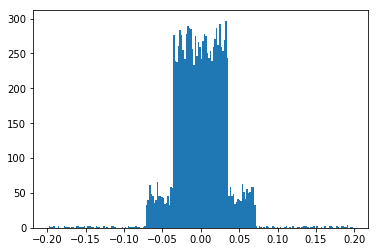

In [209]:
_ = plt.hist(orig_params_flat, bins=200)
plt.show()

In [210]:
final_params = []
for param in best_model.parameters():
  final_params.append(param.data.cpu().numpy().flatten())
final_params_flat = np.concatenate(final_params)

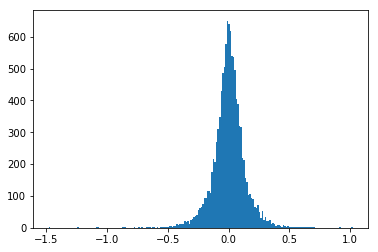

In [211]:
_ = plt.hist(final_params_flat, bins=200)
plt.show()